# Проект: Турникеты

**Кто там? Предскажите, кто вошел в здание по времени и турникету. Мы знаем, что "след" через турникеты принадлежит "Х". Кто этот "Х" предстоит вычислить по данным, которые нам известны. А ID юзеров известны по обучающей выборке (кроме нескольких новых!).
В тестовой выборке id посетителей заменены на слова: aucroc, binary, blue, categorical и т.п.**

## Ход проекта

1. Загрузка данных и их анализ.
2. Исследовательский анализ и предобработка данных.
3. Подготовка данных, генерация фич.
4. Обучение модели.
5. Раздача ID посетителям алгоритмом относительно шанса предсказанного моделью.
6. Общий вывод.

In [5]:
import pandas as pd
import os
import numpy as np
import phik
import seaborn as sns
import warnings
from IPython.display import display
from datetime import datetime
from imblearn.over_sampling import SMOTE 

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.impute import SimpleImputer

from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
RS = 15

C:\Users\bezth\anaconda3\envs\ds_practicum_env\lib\site-packages\phik\simulation.py:28: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def sim_2d_data(hist:np.ndarray, ndata:int=0) -> np.ndarray:


# Загрузка и знакомство с данными

In [6]:
def load(pth1, pth2):
    
    if os.path.exists(pth1):
        df = pd.read_csv(pth1, parse_dates=['ts'], index_col=0)
        return df
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, parse_dates=['ts'], index_col=0)
        return df
    else:
        print('Something is wrong')

In [7]:
fold1 = '/data/'
fold2 = 'C:/Users/bezth/pract/gate_test/data/'
csv = ['train.csv', 'test.csv']

all_df = []
for i in range(len(csv)):
    all_df.append(i)
    all_df[i] = load(fold1+csv[i], fold2+csv[i])
    display(all_df[i].head(10))

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
5,18,2022-07-29 09:10:34,10
6,18,2022-07-29 09:32:47,11
7,18,2022-07-29 09:33:12,4
8,18,2022-07-29 09:33:13,4
9,1,2022-07-29 09:33:16,7


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
37523,2023-01-03 08:32:49,15,epsilon
37524,2023-01-03 08:36:02,9,epsilon
37525,2023-01-03 08:36:02,9,epsilon
37526,2023-01-03 08:36:14,5,epsilon
37527,2023-01-03 08:36:16,5,epsilon


In [8]:
for i in range(len(csv)):
    print('='*15, csv[i], '='*15)
    print()
    all_df[i].info()
    print(end='\n'*3)

=============== train.csv ===============

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB



=============== test.csv ===============

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB





**Два датафрейма, тестовая и обучающая выборка. В обучающей выборке известны ID, в тестовой ID заменены на слова.**
**Из данных только проходы по разным турникетам в разное время**

## Исследовательский анализ и предобработка данных.

In [9]:
len(all_df[1])/len(all_df[0])

0.1899088437549976

**Размер тестовой выборки относительно обучающей 0.18**

In [10]:
len(all_df[0]['user_id'].unique())

56

In [11]:
sorted(all_df[0]['gate_id'].unique())

[-1, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [12]:
sorted(all_df[1]['gate_id'].unique())

[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

**В трейне на один турникет больше, к тому же отсутствует второй турникет, в тестовых нету нулевого турникета.**

In [13]:
gates = list(set(all_df[0]['gate_id'].unique()) & set(all_df[1]['gate_id'].unique()))

**Получаем список из пересечений турникетов в обоих датафреймах**

In [14]:
all_df[0] = all_df[0].loc[all_df[0]['gate_id'].isin(gates)]
all_df[1] = all_df[1].loc[all_df[1]['gate_id'].isin(gates)]

**Оставляем турникеты которые есть только в обоих выборках**

In [15]:
print(all_df[0].isna().sum())
print(all_df[1].isna().sum())

user_id    0
ts         0
gate_id    0
dtype: int64
ts           0
gate_id      0
user_word    0
dtype: int64


**Проверка на пропуски**

In [16]:
users = list(all_df[0]['user_id'].unique())
word = list(all_df[1]['user_word'].unique())

**Получаем списки ID и имён посетителей**

In [17]:
df = pd.concat(all_df, axis=0)

**Объеденяем данные**

In [18]:
df.duplicated().sum()

2851

In [19]:
df.drop_duplicates(inplace=True) # Дроп будликатов

**Проверка на дубликаты и их дроп**

In [20]:
df.groupby('gate_id').count()

,user_id,ts,user_word
gate_id,,,
-1,25,26,1
1,5,7,2
3,5220,6113,893
4,7980,9411,1431
5,4554,5407,853
6,1741,2023,282
7,3026,3566,540
8,24,34,10
9,1729,2123,394


In [21]:
df = df[df['gate_id'] != -1]

**Турникет под номером -1 не представляет интереса, так-как его почти нет в тестовой выборке, дроп строк с этим турникетом**

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41756 entries, 0 to 44641
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    35141 non-null  float64       
 1   ts         41756 non-null  datetime64[ns]
 2   gate_id    41756 non-null  int64         
 3   user_word  6615 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [23]:
df['user_id'] = df['user_id'].astype('object')
df['gate_id'] = df['gate_id'].astype('object')

**Изменяю тип данных на объект так-как после объеденения данные стали float.**

In [24]:
df['user_id'].unique()

array([18.0, 1.0, 3.0, 6.0, 29.0, 55.0, 24.0, 39.0, 47.0, 33.0, 0.0, 31.0,
       37.0, 26.0, 50.0, 49.0, 53.0, 20.0, 54.0, 19.0, 12.0, 46.0, 27.0,
       25.0, 11.0, 15.0, 9.0, 48.0, 40.0, 56.0, 34.0, 22.0, 45.0, 23.0,
       57.0, 4.0, 8.0, 52.0, 32.0, 28.0, 7.0, 36.0, 42.0, 14.0, 35.0,
       17.0, 5.0, 38.0, 41.0, 43.0, 10.0, 51.0, 21.0, 30.0, 44.0, 2.0,
       nan], dtype=object)

In [25]:
len(df['user_id'].unique()) # 56 уникальных ID

57

**56 уникальных ID**

In [26]:
df['user_word'].unique()

array([nan, 'gini', 'epsilon', 'fit', 'recall', 'linear', 'target',
       'significant', 'ols', 'f1', 'loss', 'binary', 'minimization',
       'pvalue', 'collinear', 'predict', 'blue', 'lasso', 'residual',
       'logistic', 'categorical', 'independent', 'aucroc', 'sigmoid', 'x',
       'matrix', 'distributed', 'mse', 'ridge', 'r2', 'tstat',
       'coefficient', 'regression', 'y', 'precision'], dtype=object)

In [27]:
len(df['user_word'].unique())

35

**34 уникальных имени**

In [28]:
df['minute'] = df['ts'].dt.minute.values
df['day'] = df['ts'].dt.day.values      # Разбиваю дату на фичи.
df['hour'] = df['ts'].dt.hour.values
df['day_of_week'] = df['ts'].dt.dayofweek.values
df['month'] = df['ts'].dt.month.values

In [29]:
df

,user_id,ts,gate_id,user_word,minute,day,hour,day_of_week,month
0,18.0,2022-07-29 09:08:54,7,NaN,8,29,9,4,7
1,18.0,2022-07-29 09:09:54,9,NaN,9,29,9,4,7
3,18.0,2022-07-29 09:10:06,5,NaN,10,29,9,4,7
4,18.0,2022-07-29 09:10:08,5,NaN,10,29,9,4,7
5,18.0,2022-07-29 09:10:34,10,NaN,10,29,9,4,7
...,...,...,...,...,...,...,...,...,...
44637,NaN,2023-02-24 17:08:57,10,collinear,8,24,17,4,2
44638,NaN,2023-02-24 19:43:36,11,collinear,43,24,19,4,2
44639,NaN,2023-02-24 19:44:00,4,collinear,44,24,19,4,2
44640,NaN,2023-02-24 19:44:01,4,collinear,44,24,19,4,2


In [30]:
df['user_id'] = df['user_id'].replace(0, 100) # Здесь небольшая загвоздка, так-как далее я предсказываю каждый класс 
df['user_id'] = df['user_id'].replace(1, 101) # по отдельности и выдаю им значения 1 и 0, то пришлось здесь поменять ник
                                              # юзеров, проблема в том что я незнаю можно ли при обучении использовать
                                              # значения кроме True и False.
        
users = list(df['user_id'].unique()) # Обновляю список ID

In [31]:
user_id = df[df['user_id'].isin(users)]
user_word = df[df['user_word'].isin(word)]

In [32]:
user_id.shape

(41756, 9)

In [33]:
user_word.shape

(6615, 9)

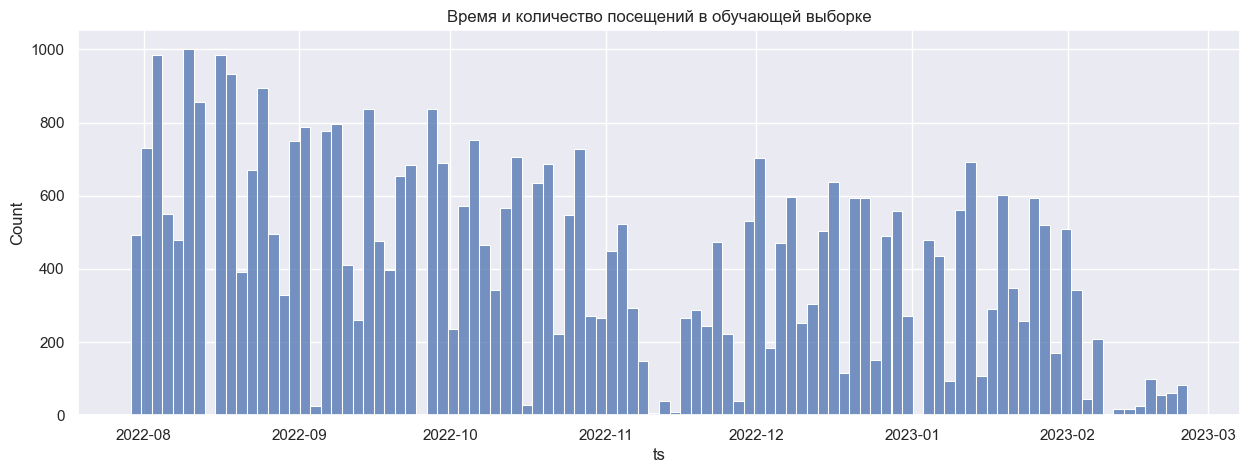

In [34]:
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(user_id['ts'], 
             bins=100).set_title('Время и количество посещений в обучающей выборке');

**Временной отрезок обучающей выборки с августа по конец 2022 года. Количество посещений уменьшается что косвенно говорит о том что самих посетителей становится меньше.**

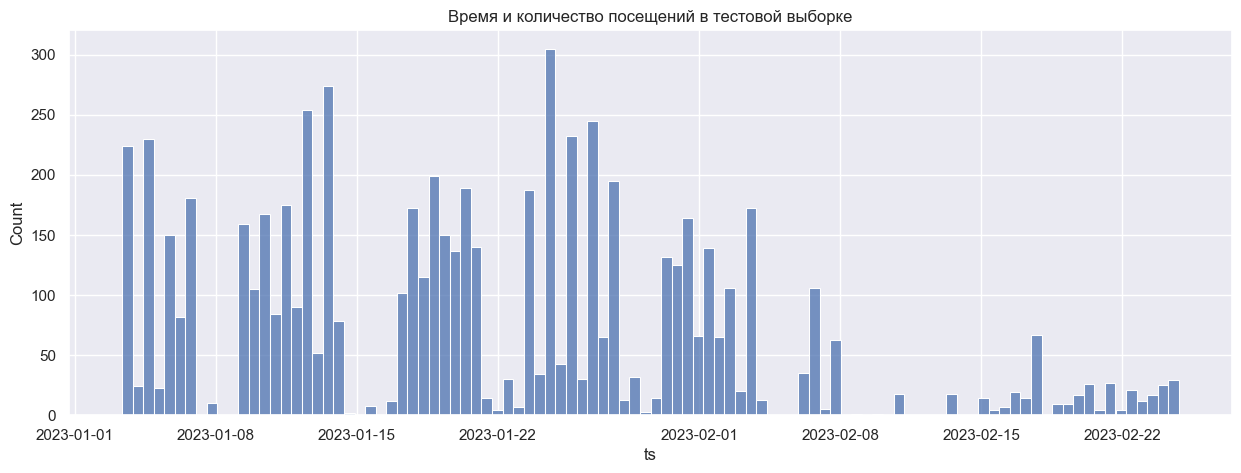

In [35]:
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(user_word['ts'], 
             bins=100).set_title('Время и количество посещений в тестовой выборке');

**В тестовой выборке временной отрезок с начала 2023 года по 22 февраля. В феврале подозрительно спадает частота посещений.**

In [36]:
user_id['user_id'].where(user_id['month'] == 12).unique()

array([ nan,   3.,   6., 101.,  17.,  55.,  19.,  35.,  11.,  37.,  33.,
        32., 100.,  49.,  12.,  39.,  50.,  29.,   9.,  15.,  54.,  43.,
        14.,  26.,  24.,  46.,  41.,  22.,  10.,  34.,  25.,  36.,  56.,
        23.,  51.,  21.,  30.,  53.,  18.,  48.,  47.,  44.,   2.])

In [37]:
users = user_id['user_id'].where(user_id['month'] == 12).unique()

**Здесь оставляем ID только тех юзеров кто работал в декабре, так-как другие могли уволиться и далее не появляется в тестовой выборке.**

In [38]:
len(users) - 1 # -1 это nan

42

**Из 56 посетителей осталось 42**

In [39]:
user_id = df[df['user_id'].isin(users[1:])]

In [40]:
user_id.groupby('user_id')['user_id'].count()

user_id
2.0        39
3.0       894
6.0      1856
9.0      1015
10.0       17
11.0     1254
12.0     1837
14.0      617
15.0     1659
17.0      648
18.0     1441
19.0     1661
21.0        4
22.0       87
23.0      246
24.0      386
25.0      234
26.0      278
29.0      923
30.0       10
32.0     1020
33.0     1184
34.0      267
35.0      549
36.0       43
37.0     2184
39.0     1032
41.0      110
43.0      117
44.0        4
46.0      467
47.0     1250
48.0      712
49.0     1129
50.0      965
51.0        2
53.0     1279
54.0      977
55.0     2164
56.0      123
100.0    1184
101.0    1170
Name: user_id, dtype: int64

In [41]:
user_word.groupby('user_word')['user_word'].count()

user_word
aucroc           37
binary          362
blue             12
categorical     241
coefficient      56
collinear       298
distributed     117
epsilon         336
f1              693
fit             183
gini            253
independent     278
lasso            33
linear          199
logistic          5
loss            458
matrix          157
minimization     95
mse             103
ols             139
precision        54
predict         208
pvalue          181
r2              185
recall          210
regression       50
residual        224
ridge           141
sigmoid         432
significant     277
target          111
tstat           139
x               298
y                50
Name: user_word, dtype: int64

In [42]:
user_id[user_id['user_id'] == 2].tail(1)

,user_id,ts,gate_id,user_word,minute,day,hour,day_of_week,month
37441,2.0,2022-12-30 17:55:00,4,NaN,55,30,17,4,12


In [43]:
user_word[user_word['user_word'] == 'aucroc'].head(1)

,user_id,ts,gate_id,user_word,minute,day,hour,day_of_week,month
37824,NaN,2023-01-04 11:07:00,15,aucroc,7,4,11,2,1


**На этом этапе внимательно изучаем каждого посетителя в обоих выборках**

**Было выяснено что некоторые пользователи из обучающей выборки бывали в декабре по одному разу, какие-то вообще появляются только один раз за всё время, в тестовой выборке есть два пользователя которые начали работать только в конце января, и также есть которые появляются только один раз, принято решение удалить их.**

In [44]:
user_id.groupby('user_id')['user_id'].count()

user_id
2.0        39
3.0       894
6.0      1856
9.0      1015
10.0       17
11.0     1254
12.0     1837
14.0      617
15.0     1659
17.0      648
18.0     1441
19.0     1661
21.0        4
22.0       87
23.0      246
24.0      386
25.0      234
26.0      278
29.0      923
30.0       10
32.0     1020
33.0     1184
34.0      267
35.0      549
36.0       43
37.0     2184
39.0     1032
41.0      110
43.0      117
44.0        4
46.0      467
47.0     1250
48.0      712
49.0     1129
50.0      965
51.0        2
53.0     1279
54.0      977
55.0     2164
56.0      123
100.0    1184
101.0    1170
Name: user_id, dtype: int64

In [45]:
count = user_id.groupby('user_id')['user_id'].count()
count = count[count > 30]

users = []                        
for i in count.index:
    users.append(i)

user_id = user_id[user_id['user_id'].isin(users)]

**Удаляем тех кто проходил меньше 30 раз**

In [46]:
len(user_id['user_id'].unique())

37

In [47]:
user_month = user_id[user_id['month'] == 12]
count = user_month.groupby('user_id')['user_id'].count()
count = count[count > 20]

users = []                        
for i in count.index:
    users.append(i)

user_id = user_id[user_id['user_id'].isin(users)]

**Удаляем тех кого не было в декабре**

In [48]:
len(user_id['user_id'].unique())

30

**ID почистили..**

In [49]:
len(user_word['user_word'].unique())

34

In [50]:
user_month = user_word[user_word['month'] == 1]

In [51]:
count = user_month.groupby('user_word')['user_word'].count()
new_count = count[count < 30]

new_users = []                        
for i in new_count.index:
    new_users.append(i)

try:
    new_users.remove('lasso')
except:
    pass
new_users

['blue', 'logistic', 'precision', 'y']

**Logistic и Blue может быть случайные, позже запишем их ID как -999(Новый работник), также Precision и Y появляются только в конце месяца, либо новые работники либо были в отпуске? В общем тоже -999. Lasso ходит непонятно, его пришлось вернуть вручную..**

In [52]:
user_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27922 entries, 9 to 37516
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      27922 non-null  float64       
 1   ts           27922 non-null  datetime64[ns]
 2   gate_id      27922 non-null  object        
 3   user_word    0 non-null      object        
 4   minute       27922 non-null  int64         
 5   day          27922 non-null  int64         
 6   hour         27922 non-null  int64         
 7   day_of_week  27922 non-null  int64         
 8   month        27922 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 2.1+ MB


In [53]:
user_word.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6615 entries, 37518 to 44641
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      0 non-null      float64       
 1   ts           6615 non-null   datetime64[ns]
 2   gate_id      6615 non-null   object        
 3   user_word    6615 non-null   object        
 4   minute       6615 non-null   int64         
 5   day          6615 non-null   int64         
 6   hour         6615 non-null   int64         
 7   day_of_week  6615 non-null   int64         
 8   month        6615 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 516.8+ KB


### **Промежуточный вывод:**

**Были обнаружены и удалены дубликаты**

**Обнаруженно что множества турникетов в датафреймах отличаются, оставленны турникеты являющиеся пересечением этих множеств.**

**Временной отрезок двух датафреймов с августа 2022 года по февраль 2023 года, обучающая выборка до конца 2022 года, тестовая с начала 2023.**

**Удалены посетители которые ходили только до декабря, также обнаружены и удалены посетители которые появлялись в декабре лишь раз, подобный анализ был и по тестовой выборке, только подобным поcетителям принято решение в дальнейшем задать ID -999(Что означает новый посетитель которого раньше не было).**

**В конечном итоге осталось 34 уникальных ID пользователей что равно 34 уникальных имени в тестовой выборке.**

## Подготовка данных, генерация фич.

In [54]:
def get_prev(k):

    prev = user_id[user_id['user_id'] == users[0]]['gate_id'].shift(-k)
        
    for i in users[1:]:   # отдельным столбцом записывается значение предидущего прохода.
        y = []            # Далее к ней можно обращаться для генерации нужного количества проходов.
        y = user_id[user_id['user_id'] == i]['gate_id'].shift(-k)        
        prev = pd.concat([prev, y], axis=0)
        
    return prev

In [55]:
def get_prev2(k):
    
    prev = user_word[user_word['user_word'] == word[0]]['gate_id'].shift(-k)
    
    for i in word[1:]:
        y = []
        y = user_word[user_word['user_word'] == i]['gate_id'].shift(-k)        
        prev = pd.concat([prev, y], axis=0)
        
    return prev

In [56]:
for i in range(1, 10):
    user_id[f'prev_gate_{i}'] = get_prev(i)
    user_word[f'prev_gate_{i}'] = get_prev2(i)

**Добавляем в датафреймы предидущие проходы через турникеты каждого посетителя. В следствии чего образуются nan значения.**

In [57]:
user_id.drop('user_word', axis=1, inplace=True)
user_word.drop('user_id', axis=1, inplace=True)

user_id.dropna(inplace=True)
user_word.dropna(inplace=True)

**Дроп образовавшихся nan значений.**

In [58]:
df = pd.concat([user_id, user_word], axis=0)

**Объеденяем данные**

In [59]:
df.drop('ts', axis = 1, inplace=True)
df.drop('month', axis = 1, inplace=True)

**Дроп значения месяца и дроп дат**

In [60]:
df['hour'] = df['hour'].astype('object')
df['day'] = df['day'].astype('object')
df['minute'] = df['minute'].astype('object')
df['day_of_week'] = df['day_of_week'].astype('object')
df['gate_id'] = df['gate_id'].astype('object')
df['user_id'] = df['user_id'].astype('object')

**Изменяем тип данных на object**

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33965 entries, 9 to 44609
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      27652 non-null  object
 1   gate_id      33965 non-null  object
 2   minute       33965 non-null  object
 3   day          33965 non-null  object
 4   hour         33965 non-null  object
 5   day_of_week  33965 non-null  object
 6   prev_gate_1  33965 non-null  object
 7   prev_gate_2  33965 non-null  object
 8   prev_gate_3  33965 non-null  object
 9   prev_gate_4  33965 non-null  object
 10  prev_gate_5  33965 non-null  object
 11  prev_gate_6  33965 non-null  object
 12  prev_gate_7  33965 non-null  object
 13  prev_gate_8  33965 non-null  object
 14  prev_gate_9  33965 non-null  object
 15  user_word    6313 non-null   object
dtypes: object(16)
memory usage: 4.4+ MB


In [62]:
len(word)

34

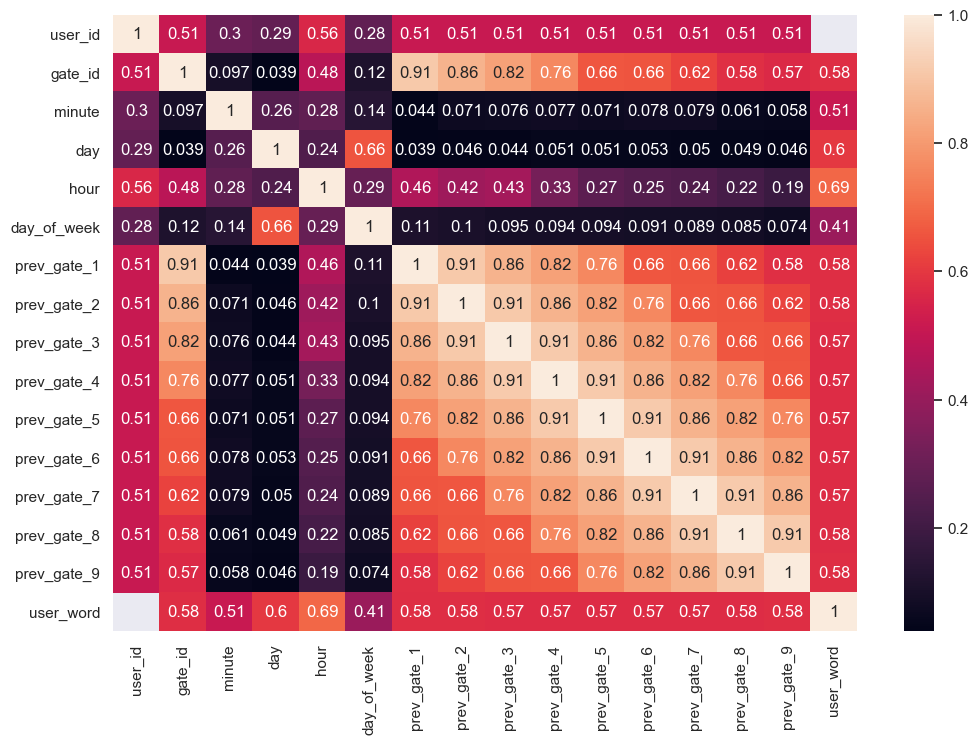

In [63]:
sns.set(rc={'figure.figsize':(12,8)})
#interval_cols = [x for x in df.columns if df[x].dtype=='int64']
sns.heatmap(df.phik_matrix(), annot=True);

**Матрица корреляции показывает слишком высокие значения между турникетами, были опробованны варианты делать турникеты с шагом в 3, что-бы корреляция была не выше 0.82, но как ни странно в таком виде было угаданно меньше пользователей при абсолютно одинаковом алгоритме раздачи ID.**

In [64]:
train = df[df['user_id'].isin(users)] # Разбиваю выборки обратно.
test = df[df['user_word'].isin(word)]

In [65]:
train['user_id'] = train['user_id'].astype('int64')

In [66]:
test2 = test.copy()   # Далее они используются как каркас для работы в функции, 
train2 = train.copy() # если этого не сделать функция с моделью даст ошибку.

In [67]:
X_train = train.drop(['user_id', 'user_word'], axis=1)
y_train = train['user_id'].astype('int64')

In [68]:
X_test = test.drop(['user_word', 'user_id'], axis=1)
y_test = test['user_word']

In [69]:
num = [x for x in X_train.columns if X_train[x].dtype!='object'] # Получаем списки числовых и категориальных колонок.
cat = [x for x in X_train.columns if X_train[x].dtype=='object']

In [70]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', drop='first') # Настриваем кодировщик

std_scaler = StandardScaler()
pipe_num = Pipeline([('scaler', std_scaler)]) # Конвеер трансформации числовых столбцов

s_imputer = SimpleImputer(strategy='constant', fill_value='unknown') # Импутируем пропуски затычкой

In [71]:
# Конвеер трансформации категориальнов столбцов     
pipe_cat = Pipeline([('imputer', s_imputer), ('encoder', encoder_ohe)])  

# Ветвление трансформеров
col_transformer = ColumnTransformer([('num_preproc', pipe_num, num),
                                     ('cat_preproc', pipe_cat, cat)])

In [72]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27652 entries, 9 to 37459
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gate_id      27652 non-null  object
 1   minute       27652 non-null  object
 2   day          27652 non-null  object
 3   hour         27652 non-null  object
 4   day_of_week  27652 non-null  object
 5   prev_gate_1  27652 non-null  object
 6   prev_gate_2  27652 non-null  object
 7   prev_gate_3  27652 non-null  object
 8   prev_gate_4  27652 non-null  object
 9   prev_gate_5  27652 non-null  object
 10  prev_gate_6  27652 non-null  object
 11  prev_gate_7  27652 non-null  object
 12  prev_gate_8  27652 non-null  object
 13  prev_gate_9  27652 non-null  object
dtypes: object(14)
memory usage: 3.2+ MB


In [73]:
f1 = make_scorer(f1_score , average='macro')

### Промежуточный вывод:

**Были добавлены колонки со значениями в виде предидущих проходов посетителя через турникеты, таким образом образуется след посетителя из ID турникетов.**

**Настроили pipeline, encoder, imputer, columntransformer**

## Обучение модели

In [74]:
def find_user(user): # Написал функцию в которой происходит раздача целевому юзеру значение 1, а остальным 0.
    
    train = df[df['user_id'].isin(users)]
    test = df[df['user_word'].isin(word)]
    
    train.loc[train['user_id'] != user, 'user_id'] = 0
    train.loc[train['user_id'] == user, 'user_id'] = 1
    
    X_train = train.drop(['user_id', 'user_word'], axis=1)
    y_train = train['user_id'].astype('int64')
    
    oversampled = SMOTE(random_state=RS)  # Боремся с дисбалансом классов.
    X_train_res, y_train_res = oversampled.fit_resample(X_train, y_train)
    
    model_lg = LGBMClassifier(random_state = RS)

    params = {
        'model__verbose': [-1],
        'model__num_leaves': [20, 40],
        'model__learning_rate': [0.1],
        'model__max_depth': [None, 7],
        'model__n_estimators': [1],
        'model__num_iterations': [25, 50, 100, 200]
    }

    final_pipe = Pipeline([('preproc', col_transformer),
                           ('model', model_lg)])

    grid = GridSearchCV(final_pipe, param_grid = params, cv=5, scoring = f1)
    
    grid.fit(X_train_res, y_train_res)
    lg_score = grid.best_score_
    print(grid.best_params_)

    print(f'score for {user}: {lg_score}')
    print()
    
    pred_proba_t = grid.predict_proba(X_test)
    pred_proba_test = pred_proba_t[:, 1]
    
    pred_proba_tr = grid.predict_proba(X_train)
    pred_proba_train = pred_proba_tr[:, 1]
    
    train2['user_' + str(user)] = pred_proba_train # Здесь для каждого посетителя создаётся колонка с вероятностями
    test2['user_' + str(user)] = pred_proba_test   # относительно значений строки.
    
    return train2, test2

In [75]:
for i in sorted(users):    
    x = find_user(int(i))
    print()

{'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 1, 'model__num_iterations': 200, 'model__num_leaves': 40, 'model__verbose': -1}
score for 2: 0.9971398917042956


{'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 1, 'model__num_iterations': 200, 'model__num_leaves': 40, 'model__verbose': -1}
score for 3: 0.9681362081996697


{'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 1, 'model__num_iterations': 50, 'model__num_leaves': 20, 'model__verbose': -1}
score for 6: 0.9424532869489874


{'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 1, 'model__num_iterations': 100, 'model__num_leaves': 40, 'model__verbose': -1}
score for 9: 0.974598413418817


{'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 1, 'model__num_iterations': 50, 'model__num_leaves': 40, 'model__verbose': -1}
score for 11: 0.9655237147301428


{'model__learning_rate': 0.1, 'model_

### Промежуточный вывод:

**Обучение настроено так что-бы предсказывать каждый ID по отдельности с балансировкой классов в тренировачной выборке.**

## Раздача ID посетителям.

**Сложность раздачи в том что модель раздаёт одни и теже ID одним и тем же посетителям, значит надо написать такой алгоритм который раздаст всем посетителям разные ID относительно вероятности предсказания модели, но также есть загвоздка что если у одного посетителя очень вероятно похожи 20 проходов из его 50 общих проходов во всем датасете, а у другого 10 из 20, то раздавать просто по количеству похожих проходов будет не верно, значит нам надо высчитать коэффициент, где 20 из 50 будет меньше чем 10 из 20, и укого такой коэффициент выше тому посетителю и будем передавать ID. Далее ID и имя посетителя удаляем и ищем следующего.**

In [76]:
tr = x[0].copy()  
tt = x[1].copy() # Копирую трейн и тест фреймб.

In [77]:
def chance(user): # Функция которая возвращает максимальную вероятность соотвествия ID и имени посетителя.
    return tt['user_'+str(user)].max()

In [78]:
pred = {}

In [79]:
for i in new_users:
    pred[i] = -999   # Список с новыми посетителями.
    tt = tt[tt['user_word'] != i]

In [80]:
users2 = []
for i in users: # Создаётся новый список, который будет итерироваться и сокращаться мо мере раздачи ID посетителям.
    users2.append(int(i))

In [81]:
dict_max = {}
for i in users2:        # Создаётся словарь в котором записаны ID юзеров и их максимальные значения вероятности с
                        # определенным именем посетителя.
    dict_max[int(i)] = chance(int(i))    
dict_max[2] = 0.1      # Модель обещает предсказать юзера2 с максимальной вероятностью а потом не находит его.
                       # Из-за чего ломается раздача ID, поэтому пошёл на такую уловку.

In [82]:
no_zavod = {} # Словарь по которому дальше анализировал получившееся результаты.
              # В нём собираются данные какой ID кому присвоен и при каком коэффициенте совпадения относительно
              # общего числа проходов..
        
for i in range(len(users)):     
    
    max_val = max(dict_max.values())              # Из словаря dict_max  берутся значения с максимальной
    max_val_key = max(dict_max, key=dict_max.get) # вероятностью предсказанного ID.
    
    print("Max element of a dict:", max_val, "with the key:", max_val_key)

    dict_max.pop(max_val_key)          # Взятое значение удаляется. 
    
    prob = max_val # Далее переменная prob будет уменьшаться до тех пор пока не наберётся 
    
    print(prob)    # нужная сумма проходов через турникеты.
    
    summa = 1      # Переменная отвечающая за остановку цикла, она увеличивается относительно набранной сумме турникетов.
    
    dict_frequency = {} # Здесь создаётся словарь который в дальнейшем будет использован для вычисления максимального
                        # коэффициента среди разных посетителей в зависимости от общего числа проходов через турникеты.
    
    while_count = 0  # Счётчик для остановки цикла в случае если нужного количества проходов не набирается.
                          
    while summa < 110: # Здесь мы можем регулировать сумму проходов по которому возьмётся максимальный коэффициент.
        while_count += 1
        prob -= 0.01
        
        # Переменная summa увеличивается при уменьшении перменной prob, в ней накапливается сумма проходов относительно
        # вероятности.
        summa = tt[tt['user_'+str(max_val_key)] > prob].groupby('user_word')['user_word'].count().sum()
        
        # Переменная numb, серия в которой index это имя посетителя, и значение равное количеству его проходов.
        numb = tt[tt['user_'+str(max_val_key)] > prob].groupby('user_word')['user_word'].count()
        
        # Тоже что и numb только здесь одни имена.
        numb_ind = tt[tt['user_'+str(max_val_key)] > prob].groupby('user_word')['user_word'].count().index
        
        for i, j in zip(numb, numb_ind):
            
            # Переменная numb_all в ней мы получаем общее количество проходов через турникеты 
            # определенного посетителя по всему датафрейму
            numb_all = test2[test2['user_word'] == j].groupby('user_word')['user_word'].count().values
            
            frequency = i/numb_all[0] # Здесь вычисляется коэффициент равный тому сколько проходов
                                      # совпадает из перменной numb с общим количеством проходов посетителя.
            # К примеру: когда мы получаем список где aucroc прошёл 10 турникетов и significant прошёл 10,
            # то происходит рассчёт такой что у aucroc совпадает 10 из 40 проходов, а у significant 10 из 100,
            # соответственно вероятность что aucroc предсказан точнее выше, чем у significant.
                
            if frequency == 1 and len(users2) > 1:   
                dict_frequency[j] = frequency  # Что-бы словарь не выходил пустым.
                break                         
                
            dict_frequency[j] = frequency      # Получившиеся результаты записываются в словарь                                
            print(j, i, numb_all[0], frequency)
        print()
        
        if while_count > 80:  # Остановка цикла в случае если нужное количество проходов не набрано.
            print('stop')     # Также этим значением можно регулировать диапозон вероятностей.
            break
    
    
    if len(users2) != 1:
        ind = max(dict_frequency, key=dict_frequency.get)
        freq = max(dict_frequency.values())    # Здесь переменной ind присваевается имя посетителя с получившимся
                                               # максимальным коэффициентом совпадения.   
    if len(users2) == 1:                             
        ind = list(tt[tt['user_'+str(max_val_key)] > 0].groupby('user_word')['user_word'].count().index)[0]
                                               # Последний проход.
        
    print(ind, max_val_key, freq, summa, 'here')
    
    print()
    
    pred[ind] = max_val_key   # Заполняем словарь получившимися именами и ID посетителя.
    
    tt = tt[tt['user_word'] != ind]             # Удаляем из датафрейма разгаданного посетителя
    no_zavod[max_val_key] = [ind, freq, summa]  # В переменную no_zavod добавляются данные для последующего анализа.
    users2.remove(max_val_key)                  # Также удаляем разгаданный ID
pred

Max element of a dict: 0.9981096735532992 with the key: 14
0.9981096735532992
categorical 4 232 0.017241379310344827
collinear 1 289 0.0034602076124567475
gini 1 244 0.004098360655737705

categorical 6 232 0.02586206896551724
collinear 2 289 0.006920415224913495
gini 2 244 0.00819672131147541

categorical 10 232 0.04310344827586207
collinear 2 289 0.006920415224913495
gini 2 244 0.00819672131147541

categorical 11 232 0.04741379310344827
collinear 2 289 0.006920415224913495
epsilon 1 327 0.0030581039755351682
gini 2 244 0.00819672131147541

categorical 15 232 0.06465517241379311
collinear 2 289 0.006920415224913495
epsilon 2 327 0.0061162079510703364
gini 3 244 0.012295081967213115

categorical 16 232 0.06896551724137931
collinear 3 289 0.010380622837370242
epsilon 3 327 0.009174311926605505
gini 4 244 0.01639344262295082

binary 1 353 0.0028328611898017
categorical 21 232 0.09051724137931035
collinear 3 289 0.010380622837370242
epsilon 3 327 0.009174311926605505
gini 4 244 0.016393442

binary 1 353 0.0028328611898017
coefficient 1 47 0.02127659574468085
epsilon 18 327 0.05504587155963303
fit 2 174 0.011494252873563218
independent 9 269 0.03345724907063197
predict 2 199 0.010050251256281407
sigmoid 2 423 0.004728132387706856

aucroc 6 28 0.21428571428571427
binary 1 353 0.0028328611898017
coefficient 1 47 0.02127659574468085
epsilon 18 327 0.05504587155963303
fit 2 174 0.011494252873563218
independent 9 269 0.03345724907063197
predict 2 199 0.010050251256281407
sigmoid 2 423 0.004728132387706856

aucroc 6 28 0.21428571428571427
binary 1 353 0.0028328611898017
coefficient 1 47 0.02127659574468085
epsilon 18 327 0.05504587155963303
fit 2 174 0.011494252873563218
independent 9 269 0.03345724907063197
predict 2 199 0.010050251256281407
sigmoid 2 423 0.004728132387706856

aucroc 6 28 0.21428571428571427
binary 1 353 0.0028328611898017
coefficient 1 47 0.02127659574468085
epsilon 19 327 0.0581039755351682
fit 2 174 0.011494252873563218
independent 10 269 0.03717472118959108

binary 2 353 0.0056657223796034
coefficient 3 47 0.06382978723404255
collinear 1 289 0.0034602076124567475
epsilon 32 327 0.09785932721712538
f1 1 684 0.0014619883040935672
fit 4 174 0.022988505747126436
independent 17 269 0.06319702602230483
matrix 1 148 0.006756756756756757
mse 2 94 0.02127659574468085
predict 7 199 0.035175879396984924
residual 2 215 0.009302325581395349
sigmoid 11 423 0.026004728132387706

aucroc 6 28 0.21428571428571427
binary 2 353 0.0056657223796034
coefficient 3 47 0.06382978723404255
collinear 1 289 0.0034602076124567475
epsilon 32 327 0.09785932721712538
f1 1 684 0.0014619883040935672
fit 4 174 0.022988505747126436
independent 17 269 0.06319702602230483
matrix 1 148 0.006756756756756757
mse 2 94 0.02127659574468085
predict 7 199 0.035175879396984924
residual 2 215 0.009302325581395349
sigmoid 11 423 0.026004728132387706

aucroc 6 28 0.21428571428571427
binary 2 353 0.0056657223796034
coefficient 3 47 0.06382978723404255
collinear 1 289 0.0034602076124567475
e

epsilon 20 327 0.06116207951070336
independent 12 269 0.04460966542750929
sigmoid 14 423 0.03309692671394799

epsilon 20 327 0.06116207951070336
independent 13 269 0.048327137546468404
sigmoid 15 423 0.03546099290780142

epsilon 21 327 0.06422018348623854
independent 13 269 0.048327137546468404
sigmoid 18 423 0.0425531914893617

epsilon 22 327 0.0672782874617737
independent 13 269 0.048327137546468404
sigmoid 20 423 0.04728132387706856

epsilon 22 327 0.0672782874617737
independent 13 269 0.048327137546468404
sigmoid 20 423 0.04728132387706856

epsilon 22 327 0.0672782874617737
independent 14 269 0.05204460966542751
sigmoid 20 423 0.04728132387706856

epsilon 22 327 0.0672782874617737
independent 14 269 0.05204460966542751
sigmoid 20 423 0.04728132387706856

epsilon 22 327 0.0672782874617737
independent 14 269 0.05204460966542751
sigmoid 20 423 0.04728132387706856

epsilon 23 327 0.07033639143730887
independent 16 269 0.05947955390334572
sigmoid 21 423 0.04964539007092199

epsilon 23 3

ridge 1 132 0.007575757575757576
sigmoid 4 423 0.009456264775413711

coefficient 5 47 0.10638297872340426
collinear 5 289 0.01730103806228374
fit 6 174 0.034482758620689655
gini 17 244 0.06967213114754098
independent 3 269 0.011152416356877323
matrix 1 148 0.006756756756756757
pvalue 1 172 0.005813953488372093
recall 37 201 0.18407960199004975
ridge 2 132 0.015151515151515152
sigmoid 4 423 0.009456264775413711

coefficient 5 47 0.10638297872340426
collinear 5 289 0.01730103806228374
fit 6 174 0.034482758620689655
gini 17 244 0.06967213114754098
independent 3 269 0.011152416356877323
matrix 1 148 0.006756756756756757
pvalue 1 172 0.005813953488372093
recall 38 201 0.1890547263681592
ridge 2 132 0.015151515151515152
sigmoid 4 423 0.009456264775413711

coefficient 5 47 0.10638297872340426
collinear 5 289 0.01730103806228374
fit 8 174 0.04597701149425287
gini 17 244 0.06967213114754098
independent 3 269 0.011152416356877323
matrix 1 148 0.006756756756756757
pvalue 1 172 0.00581395348837209

pvalue 6 172 0.03488372093023256
sigmoid 1 423 0.002364066193853428
significant 2 268 0.007462686567164179
target 4 102 0.0392156862745098

lasso 1 24 0.041666666666666664
predict 2 199 0.010050251256281407
pvalue 6 172 0.03488372093023256
sigmoid 1 423 0.002364066193853428
significant 2 268 0.007462686567164179
target 4 102 0.0392156862745098

lasso 1 24 0.041666666666666664
predict 2 199 0.010050251256281407
pvalue 6 172 0.03488372093023256
sigmoid 1 423 0.002364066193853428
significant 2 268 0.007462686567164179
target 4 102 0.0392156862745098

collinear 1 289 0.0034602076124567475
lasso 1 24 0.041666666666666664
predict 2 199 0.010050251256281407
pvalue 6 172 0.03488372093023256
sigmoid 1 423 0.002364066193853428
significant 2 268 0.007462686567164179
target 4 102 0.0392156862745098

collinear 1 289 0.0034602076124567475
lasso 1 24 0.041666666666666664
predict 2 199 0.010050251256281407
pvalue 6 172 0.03488372093023256
sigmoid 1 423 0.002364066193853428
significant 2 268 0.00746268

collinear 5 289 0.01730103806228374
lasso 1 24 0.041666666666666664
minimization 1 86 0.011627906976744186
predict 5 199 0.02512562814070352
pvalue 6 172 0.03488372093023256
sigmoid 2 423 0.004728132387706856
significant 5 268 0.018656716417910446
target 7 102 0.06862745098039216
x 2 289 0.006920415224913495

binary 1 353 0.0028328611898017
collinear 6 289 0.020761245674740483
lasso 1 24 0.041666666666666664
minimization 1 86 0.011627906976744186
predict 5 199 0.02512562814070352
pvalue 6 172 0.03488372093023256
sigmoid 2 423 0.004728132387706856
significant 5 268 0.018656716417910446
target 7 102 0.06862745098039216
x 2 289 0.006920415224913495

binary 1 353 0.0028328611898017
collinear 7 289 0.02422145328719723
lasso 1 24 0.041666666666666664
minimization 2 86 0.023255813953488372
predict 5 199 0.02512562814070352
pvalue 6 172 0.03488372093023256
sigmoid 3 423 0.0070921985815602835
significant 5 268 0.018656716417910446
target 7 102 0.06862745098039216
x 2 289 0.006920415224913495

b

sigmoid 1 423 0.002364066193853428
significant 27 268 0.10074626865671642
tstat 2 130 0.015384615384615385

collinear 18 289 0.06228373702422145
distributed 2 108 0.018518518518518517
f1 9 684 0.013157894736842105
linear 12 190 0.06315789473684211
matrix 2 148 0.013513513513513514
minimization 2 86 0.023255813953488372
ols 1 130 0.007692307692307693
predict 2 199 0.010050251256281407
pvalue 1 172 0.005813953488372093
regression 5 41 0.12195121951219512
residual 11 215 0.05116279069767442
sigmoid 1 423 0.002364066193853428
significant 28 268 0.1044776119402985
tstat 2 130 0.015384615384615385

collinear 19 289 0.0657439446366782
distributed 2 108 0.018518518518518517
f1 9 684 0.013157894736842105
linear 13 190 0.06842105263157895
matrix 2 148 0.013513513513513514
minimization 2 86 0.023255813953488372
ols 1 130 0.007692307692307693
predict 2 199 0.010050251256281407
pvalue 1 172 0.005813953488372093
regression 5 41 0.12195121951219512
residual 11 215 0.05116279069767442
sigmoid 1 423 0.

collinear 7 289 0.02422145328719723
distributed 1 108 0.009259259259259259
f1 1 684 0.0014619883040935672
fit 1 174 0.005747126436781609
linear 3 190 0.015789473684210527
mse 5 94 0.05319148936170213

collinear 7 289 0.02422145328719723
distributed 1 108 0.009259259259259259
f1 1 684 0.0014619883040935672
fit 1 174 0.005747126436781609
linear 3 190 0.015789473684210527
mse 5 94 0.05319148936170213

collinear 7 289 0.02422145328719723
distributed 1 108 0.009259259259259259
f1 1 684 0.0014619883040935672
fit 1 174 0.005747126436781609
linear 3 190 0.015789473684210527
mse 5 94 0.05319148936170213

collinear 7 289 0.02422145328719723
distributed 1 108 0.009259259259259259
f1 1 684 0.0014619883040935672
fit 1 174 0.005747126436781609
linear 3 190 0.015789473684210527
mse 5 94 0.05319148936170213

collinear 7 289 0.02422145328719723
distributed 1 108 0.009259259259259259
f1 1 684 0.0014619883040935672
fit 1 174 0.005747126436781609
linear 3 190 0.015789473684210527
mse 5 94 0.05319148936170

f1 1 684 0.0014619883040935672
fit 12 174 0.06896551724137931
gini 13 244 0.05327868852459016
independent 12 269 0.04460966542750929
ridge 3 132 0.022727272727272728
sigmoid 5 423 0.01182033096926714
tstat 2 130 0.015384615384615385
x 8 289 0.02768166089965398

binary 4 353 0.0113314447592068
f1 1 684 0.0014619883040935672
fit 12 174 0.06896551724137931
gini 14 244 0.05737704918032787
independent 13 269 0.048327137546468404
ridge 4 132 0.030303030303030304
sigmoid 5 423 0.01182033096926714
tstat 2 130 0.015384615384615385
x 8 289 0.02768166089965398

binary 4 353 0.0113314447592068
f1 1 684 0.0014619883040935672
fit 13 174 0.07471264367816093
gini 15 244 0.06147540983606557
independent 13 269 0.048327137546468404
ridge 4 132 0.030303030303030304
sigmoid 5 423 0.01182033096926714
tstat 2 130 0.015384615384615385
x 8 289 0.02768166089965398

binary 4 353 0.0113314447592068
f1 1 684 0.0014619883040935672
fit 13 174 0.07471264367816093
gini 17 244 0.06967213114754098
independent 13 269 0.0

matrix 2 148 0.013513513513513514
minimization 5 86 0.05813953488372093
pvalue 27 172 0.1569767441860465
regression 2 41 0.04878048780487805
residual 16 215 0.07441860465116279
sigmoid 11 423 0.026004728132387706
tstat 11 130 0.08461538461538462

binary 1 353 0.0028328611898017
collinear 6 289 0.020761245674740483
distributed 2 108 0.018518518518518517
linear 3 190 0.015789473684210527
matrix 2 148 0.013513513513513514
minimization 7 86 0.08139534883720931
pvalue 28 172 0.16279069767441862
regression 2 41 0.04878048780487805
residual 17 215 0.07906976744186046
sigmoid 12 423 0.028368794326241134
tstat 11 130 0.08461538461538462
x 1 289 0.0034602076124567475

binary 1 353 0.0028328611898017
collinear 7 289 0.02422145328719723
distributed 2 108 0.018518518518518517
linear 4 190 0.021052631578947368
matrix 2 148 0.013513513513513514
minimization 7 86 0.08139534883720931
pvalue 30 172 0.1744186046511628
regression 2 41 0.04878048780487805
residual 19 215 0.08837209302325581
sigmoid 12 423 

f1 80 684 0.11695906432748537
x 6 289 0.020761245674740483

f1 85 684 0.12426900584795321
x 7 289 0.02422145328719723

f1 93 684 0.13596491228070176
x 7 289 0.02422145328719723

f1 103 684 0.15058479532163743
x 7 289 0.02422145328719723

f1 6 0.15058479532163743 110 here

Max element of a dict: 0.9667669922764414 with the key: 50
0.9667669922764414
sigmoid 1 423 0.002364066193853428

sigmoid 1 423 0.002364066193853428

sigmoid 2 423 0.004728132387706856

sigmoid 2 423 0.004728132387706856

sigmoid 2 423 0.004728132387706856

sigmoid 2 423 0.004728132387706856

sigmoid 2 423 0.004728132387706856

regression 1 41 0.024390243902439025
sigmoid 2 423 0.004728132387706856
tstat 1 130 0.007692307692307693

regression 1 41 0.024390243902439025
sigmoid 2 423 0.004728132387706856
tstat 1 130 0.007692307692307693

regression 2 41 0.04878048780487805
residual 1 215 0.004651162790697674
sigmoid 3 423 0.0070921985815602835
tstat 1 130 0.007692307692307693

regression 2 41 0.04878048780487805
residua

sigmoid 10 423 0.02364066193853428
tstat 13 130 0.1
x 1 289 0.0034602076124567475

binary 2 353 0.0056657223796034
collinear 7 289 0.02422145328719723
distributed 4 108 0.037037037037037035
linear 11 190 0.05789473684210526
matrix 2 148 0.013513513513513514
minimization 6 86 0.06976744186046512
predict 2 199 0.010050251256281407
regression 5 41 0.12195121951219512
residual 17 215 0.07906976744186046
ridge 1 132 0.007575757575757576
sigmoid 10 423 0.02364066193853428
tstat 13 130 0.1
x 1 289 0.0034602076124567475

binary 2 353 0.0056657223796034
collinear 7 289 0.02422145328719723
distributed 4 108 0.037037037037037035
linear 11 190 0.05789473684210526
matrix 3 148 0.02027027027027027
minimization 7 86 0.08139534883720931
predict 2 199 0.010050251256281407
regression 5 41 0.12195121951219512
residual 17 215 0.07906976744186046
ridge 1 132 0.007575757575757576
sigmoid 11 423 0.026004728132387706
tstat 13 130 0.1
x 1 289 0.0034602076124567475

binary 2 353 0.0056657223796034
collinear 7 2

predict 1 199 0.005025125628140704
r2 4 176 0.022727272727272728
ridge 1 132 0.007575757575757576
sigmoid 9 423 0.02127659574468085
tstat 6 130 0.046153846153846156

binary 6 353 0.0169971671388102
coefficient 2 47 0.0425531914893617
collinear 1 289 0.0034602076124567475
gini 44 244 0.18032786885245902
matrix 2 148 0.013513513513513514
predict 1 199 0.005025125628140704
r2 4 176 0.022727272727272728
ridge 1 132 0.007575757575757576
sigmoid 9 423 0.02127659574468085
tstat 7 130 0.05384615384615385

binary 9 353 0.025495750708215296
coefficient 2 47 0.0425531914893617
collinear 1 289 0.0034602076124567475
gini 46 244 0.1885245901639344
linear 1 190 0.005263157894736842
matrix 2 148 0.013513513513513514
predict 1 199 0.005025125628140704
r2 5 176 0.028409090909090908
ridge 1 132 0.007575757575757576
sigmoid 9 423 0.02127659574468085
tstat 8 130 0.06153846153846154

binary 11 353 0.031161473087818695
coefficient 2 47 0.0425531914893617
collinear 1 289 0.0034602076124567475
gini 47 244 0.19

collinear 2 289 0.006920415224913495
distributed 2 108 0.018518518518518517
matrix 2 148 0.013513513513513514
r2 6 176 0.03409090909090909
sigmoid 25 423 0.0591016548463357
tstat 8 130 0.06153846153846154

binary 2 353 0.0056657223796034
collinear 2 289 0.006920415224913495
distributed 2 108 0.018518518518518517
matrix 2 148 0.013513513513513514
r2 6 176 0.03409090909090909
sigmoid 25 423 0.0591016548463357
tstat 9 130 0.06923076923076923

binary 2 353 0.0056657223796034
collinear 3 289 0.010380622837370242
distributed 2 108 0.018518518518518517
matrix 2 148 0.013513513513513514
r2 6 176 0.03409090909090909
sigmoid 27 423 0.06382978723404255
tstat 9 130 0.06923076923076923

binary 2 353 0.0056657223796034
collinear 4 289 0.01384083044982699
distributed 2 108 0.018518518518518517
matrix 2 148 0.013513513513513514
r2 6 176 0.03409090909090909
sigmoid 28 423 0.06619385342789598
tstat 11 130 0.08461538461538462

binary 2 353 0.0056657223796034
collinear 4 289 0.01384083044982699
distribute

binary 4 353 0.0113314447592068
collinear 5 289 0.01730103806228374
distributed 2 108 0.018518518518518517
linear 7 190 0.03684210526315789
matrix 3 148 0.02027027027027027
predict 2 199 0.010050251256281407
r2 10 176 0.056818181818181816
regression 1 41 0.024390243902439025
residual 7 215 0.03255813953488372
sigmoid 7 423 0.016548463356973995

binary 4 353 0.0113314447592068
collinear 5 289 0.01730103806228374
distributed 2 108 0.018518518518518517
linear 8 190 0.042105263157894736
matrix 3 148 0.02027027027027027
predict 2 199 0.010050251256281407
r2 10 176 0.056818181818181816
regression 1 41 0.024390243902439025
residual 8 215 0.037209302325581395
sigmoid 7 423 0.016548463356973995

binary 5 353 0.014164305949008499
collinear 6 289 0.020761245674740483
distributed 2 108 0.018518518518518517
linear 8 190 0.042105263157894736
matrix 6 148 0.04054054054054054
predict 2 199 0.010050251256281407
r2 10 176 0.056818181818181816
regression 1 41 0.024390243902439025
residual 8 215 0.0372093

collinear 3 289 0.010380622837370242
distributed 2 108 0.018518518518518517
linear 28 190 0.14736842105263157
matrix 1 148 0.006756756756756757
predict 1 199 0.005025125628140704
sigmoid 5 423 0.01182033096926714

collinear 3 289 0.010380622837370242
distributed 2 108 0.018518518518518517
linear 29 190 0.15263157894736842
matrix 1 148 0.006756756756756757
predict 1 199 0.005025125628140704
sigmoid 5 423 0.01182033096926714

collinear 3 289 0.010380622837370242
distributed 2 108 0.018518518518518517
linear 29 190 0.15263157894736842
matrix 1 148 0.006756756756756757
predict 1 199 0.005025125628140704
sigmoid 5 423 0.01182033096926714

collinear 3 289 0.010380622837370242
distributed 2 108 0.018518518518518517
linear 30 190 0.15789473684210525
matrix 1 148 0.006756756756756757
predict 2 199 0.010050251256281407
sigmoid 5 423 0.01182033096926714

collinear 3 289 0.010380622837370242
distributed 2 108 0.018518518518518517
linear 31 190 0.1631578947368421
matrix 1 148 0.006756756756756757
p

ridge 1 132 0.007575757575757576
sigmoid 7 423 0.016548463356973995

collinear 4 289 0.01384083044982699
ridge 1 132 0.007575757575757576
sigmoid 7 423 0.016548463356973995

collinear 4 289 0.01384083044982699
ridge 2 132 0.015151515151515152
sigmoid 7 423 0.016548463356973995

collinear 4 289 0.01384083044982699
ridge 3 132 0.022727272727272728
sigmoid 7 423 0.016548463356973995

collinear 4 289 0.01384083044982699
ridge 3 132 0.022727272727272728
sigmoid 7 423 0.016548463356973995

collinear 4 289 0.01384083044982699
ridge 3 132 0.022727272727272728
sigmoid 7 423 0.016548463356973995

collinear 4 289 0.01384083044982699
ridge 3 132 0.022727272727272728
sigmoid 7 423 0.016548463356973995

collinear 4 289 0.01384083044982699
ridge 3 132 0.022727272727272728
sigmoid 8 423 0.018912529550827423

collinear 5 289 0.01730103806228374
ridge 3 132 0.022727272727272728
sigmoid 8 423 0.018912529550827423

collinear 5 289 0.01730103806228374
ridge 3 132 0.022727272727272728
sigmoid 8 423 0.018912

sigmoid 16 423 0.037825059101654845

binary 15 353 0.042492917847025496
coefficient 3 47 0.06382978723404255
collinear 20 289 0.06920415224913495
distributed 6 108 0.05555555555555555
matrix 8 148 0.05405405405405406
ols 1 130 0.007692307692307693
predict 5 199 0.02512562814070352
residual 4 215 0.018604651162790697
ridge 23 132 0.17424242424242425
sigmoid 17 423 0.04018912529550828

binary 15 353 0.042492917847025496
coefficient 3 47 0.06382978723404255
collinear 22 289 0.07612456747404844
distributed 7 108 0.06481481481481481
matrix 8 148 0.05405405405405406
ols 1 130 0.007692307692307693
predict 5 199 0.02512562814070352
regression 1 41 0.024390243902439025
residual 4 215 0.018604651162790697
ridge 23 132 0.17424242424242425
sigmoid 17 423 0.04018912529550828

binary 15 353 0.042492917847025496
coefficient 4 47 0.0851063829787234
collinear 24 289 0.08304498269896193
distributed 8 108 0.07407407407407407
matrix 8 148 0.05405405405405406
ols 3 130 0.023076923076923078
predict 7 199 0.

predict 9 199 0.04522613065326633
residual 8 215 0.037209302325581395
sigmoid 15 423 0.03546099290780142

binary 3 353 0.0084985835694051
collinear 13 289 0.04498269896193772
distributed 16 108 0.14814814814814814
matrix 4 148 0.02702702702702703
ols 1 130 0.007692307692307693
predict 9 199 0.04522613065326633
residual 9 215 0.04186046511627907
sigmoid 15 423 0.03546099290780142

binary 3 353 0.0084985835694051
collinear 13 289 0.04498269896193772
distributed 17 108 0.1574074074074074
matrix 5 148 0.033783783783783786
ols 1 130 0.007692307692307693
predict 9 199 0.04522613065326633
residual 9 215 0.04186046511627907
sigmoid 15 423 0.03546099290780142

binary 4 353 0.0113314447592068
collinear 13 289 0.04498269896193772
distributed 17 108 0.1574074074074074
matrix 5 148 0.033783783783783786
ols 1 130 0.007692307692307693
predict 10 199 0.05025125628140704
residual 11 215 0.05116279069767442
sigmoid 16 423 0.037825059101654845

binary 4 353 0.0113314447592068
collinear 15 289 0.051903114

collinear 2 289 0.006920415224913495
matrix 6 148 0.04054054054054054
ols 58 130 0.4461538461538462
predict 9 199 0.04522613065326633
regression 2 41 0.04878048780487805
residual 7 215 0.03255813953488372
sigmoid 14 423 0.03309692671394799

collinear 2 289 0.006920415224913495
matrix 8 148 0.05405405405405406
ols 60 130 0.46153846153846156
predict 10 199 0.05025125628140704
regression 2 41 0.04878048780487805
residual 7 215 0.03255813953488372
sigmoid 15 423 0.03546099290780142

collinear 2 289 0.006920415224913495
lasso 1 24 0.041666666666666664
matrix 9 148 0.060810810810810814
ols 60 130 0.46153846153846156
predict 10 199 0.05025125628140704
regression 2 41 0.04878048780487805
residual 8 215 0.037209302325581395
sigmoid 15 423 0.03546099290780142

collinear 2 289 0.006920415224913495
lasso 1 24 0.041666666666666664
matrix 10 148 0.06756756756756757
ols 60 130 0.46153846153846156
predict 10 199 0.05025125628140704
regression 2 41 0.04878048780487805
residual 8 215 0.03720930232558139

sigmoid 15 423 0.03546099290780142

binary 3 353 0.0084985835694051
coefficient 3 47 0.06382978723404255
collinear 21 289 0.0726643598615917
matrix 4 148 0.02702702702702703
predict 6 199 0.03015075376884422
regression 5 41 0.12195121951219512
residual 18 215 0.08372093023255814
sigmoid 15 423 0.03546099290780142

binary 3 353 0.0084985835694051
coefficient 3 47 0.06382978723404255
collinear 22 289 0.07612456747404844
matrix 4 148 0.02702702702702703
predict 6 199 0.03015075376884422
regression 5 41 0.12195121951219512
residual 20 215 0.09302325581395349
sigmoid 16 423 0.037825059101654845

binary 4 353 0.0113314447592068
coefficient 3 47 0.06382978723404255
collinear 24 289 0.08304498269896193
matrix 4 148 0.02702702702702703
predict 6 199 0.03015075376884422
regression 5 41 0.12195121951219512
residual 20 215 0.09302325581395349
sigmoid 16 423 0.037825059101654845

binary 5 353 0.014164305949008499
coefficient 3 47 0.06382978723404255
collinear 24 289 0.08304498269896193
matrix 4 148

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 1 423 0.002364066193853428

collinear 1 289 0.0034602076124567475
residual 1 215 0.004651162790697674
sigmoid 2 423 0.004728132387706856

collinear 

sigmoid 2 423 0.004728132387706856

sigmoid 2 423 0.004728132387706856

sigmoid 4 423 0.009456264775413711

sigmoid 5 423 0.01182033096926714

sigmoid 6 423 0.014184397163120567

sigmoid 8 423 0.018912529550827423

sigmoid 10 423 0.02364066193853428

predict 1 199 0.005025125628140704
sigmoid 10 423 0.02364066193853428

predict 1 199 0.005025125628140704
sigmoid 10 423 0.02364066193853428

predict 1 199 0.005025125628140704
sigmoid 12 423 0.028368794326241134

collinear 1 289 0.0034602076124567475
matrix 1 148 0.006756756756756757
predict 1 199 0.005025125628140704
sigmoid 13 423 0.030732860520094562

collinear 1 289 0.0034602076124567475
matrix 1 148 0.006756756756756757
predict 1 199 0.005025125628140704
sigmoid 15 423 0.03546099290780142

collinear 1 289 0.0034602076124567475
matrix 2 148 0.013513513513513514
predict 1 199 0.005025125628140704
sigmoid 17 423 0.04018912529550828

collinear 1 289 0.0034602076124567475
matrix 2 148 0.013513513513513514
predict 1 199 0.00502512562814070

coefficient 11 47 0.23404255319148937
collinear 3 289 0.010380622837370242
matrix 12 148 0.08108108108108109
predict 33 199 0.1658291457286432
residual 4 215 0.018604651162790697

coefficient 11 47 0.23404255319148937
collinear 3 289 0.010380622837370242
matrix 12 148 0.08108108108108109
predict 36 199 0.18090452261306533
residual 4 215 0.018604651162790697

coefficient 12 47 0.2553191489361702
collinear 3 289 0.010380622837370242
matrix 14 148 0.0945945945945946
predict 38 199 0.19095477386934673
residual 4 215 0.018604651162790697

coefficient 12 47 0.2553191489361702
collinear 3 289 0.010380622837370242
matrix 15 148 0.10135135135135136
predict 38 199 0.19095477386934673
residual 4 215 0.018604651162790697

coefficient 13 47 0.2765957446808511
collinear 4 289 0.01384083044982699
matrix 17 148 0.11486486486486487
predict 38 199 0.19095477386934673
residual 4 215 0.018604651162790697

coefficient 13 47 0.2765957446808511
collinear 4 289 0.01384083044982699
matrix 17 148 0.114864864864

collinear 3 289 0.010380622837370242
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 3 289 0.010380622837370242
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 3 289 0.010380622837370242
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 3 289 0.010380622837370242
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 3 289 0.010380622837370242
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 3 289 0.010380622837370242
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 4 289 0.01384083044982699
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 4 289 0.01384083044982699
matrix 3 148 0.02027027027027027
residual 1 215 0.004651162790697674

collinear 4 289 0.01384083044982699
matrix 3 148 0.02027027027027027
residual 2 215 0.009302325581395349

collinear 5 289 0.01730103806228374
matr

{'blue': -999,
 'logistic': -999,
 'precision': -999,
 'y': -999,
 'categorical': 14,
 'aucroc': 26,
 'loss': 19,
 'epsilon': 24,
 'recall': 3,
 'target': 46,
 'significant': 33,
 'mse': 43,
 'fit': 101,
 'pvalue': 32,
 'independent': 49,
 'f1': 6,
 'minimization': 50,
 'x': 37,
 'gini': 15,
 'tstat': 9,
 'r2': 54,
 'linear': 17,
 'ridge': 35,
 'distributed': 100,
 'ols': 11,
 'regression': 29,
 'binary': 12,
 'lasso': 25,
 'sigmoid': 55,
 'coefficient': 39,
 'predict': 41,
 'collinear': 23,
 'matrix': 56,
 'residual': 2}

In [83]:
no_zavod

{14: ['categorical', 0.30603448275862066, 111],
 26: ['aucroc', 0.21428571428571427, 110],
 19: ['loss', 0.22494432071269488, 122],
 24: ['epsilon', 0.12538226299694188, 111],
 3: ['recall', 0.23880597014925373, 110],
 46: ['target', 0.10784313725490197, 57],
 33: ['significant', 0.12686567164179105, 111],
 43: ['mse', 0.09574468085106383, 38],
 101: ['fit', 0.13218390804597702, 113],
 32: ['pvalue', 0.19767441860465115, 113],
 49: ['independent', 0.2899628252788104, 112],
 6: ['f1', 0.15058479532163743, 110],
 50: ['minimization', 0.12790697674418605, 111],
 37: ['x', 0.28719723183391005, 110],
 15: ['gini', 0.21311475409836064, 110],
 9: ['tstat', 0.2153846153846154, 118],
 54: ['r2', 0.07954545454545454, 111],
 17: ['linear', 0.33157894736842103, 113],
 35: ['ridge', 0.17424242424242425, 114],
 100: ['distributed', 0.19444444444444445, 110],
 11: ['ols', 0.46153846153846156, 113],
 29: ['regression', 0.12195121951219512, 116],
 12: ['binary', 0.1671388101983003, 116],
 25: ['lasso',

In [84]:
len(pred)

34

In [85]:
for i in pred:
    if pred[i] == 101:
        pred[i] = 1        # Перекидываю обратно значения ID.

    if pred[i] == 100:
        pred[i] = 0
pred

{'blue': -999,
 'logistic': -999,
 'precision': -999,
 'y': -999,
 'categorical': 14,
 'aucroc': 26,
 'loss': 19,
 'epsilon': 24,
 'recall': 3,
 'target': 46,
 'significant': 33,
 'mse': 43,
 'fit': 1,
 'pvalue': 32,
 'independent': 49,
 'f1': 6,
 'minimization': 50,
 'x': 37,
 'gini': 15,
 'tstat': 9,
 'r2': 54,
 'linear': 17,
 'ridge': 35,
 'distributed': 0,
 'ols': 11,
 'regression': 29,
 'binary': 12,
 'lasso': 25,
 'sigmoid': 55,
 'coefficient': 39,
 'predict': 41,
 'collinear': 23,
 'matrix': 56,
 'residual': 2}

In [86]:
test = x[1].copy()

In [87]:
test.columns = test.columns.str.replace('user_word', 'word')
test.columns = test.columns.str.replace('user_id', 'preds')

In [88]:
answer = pd.DataFrame(test.groupby('word')['preds'].count())
for i in word:             # Из словаря pred создаём серию по образцу из постановки задачи.
    answer.loc[i] = pred.get(i)

In [89]:
answer

,preds
word,
aucroc,26
binary,12
blue,-999
categorical,14
coefficient,39
collinear,23
distributed,0
epsilon,24
f1,6


In [91]:
answer.to_csv('answer.csv') # Сохраняем ответ и отправляем на проверку.

## Общий вывод:

### Загрузка данных

**Два датафрейма, тестовая и обучающая выборка. В обучающей выборке известны ID, в тестовой ID заменены на слова.**
**Из данных только проходы по разным турникетам в разное время**

### Исследовательский анализ и предобработка данных.

**Были обнаружены и удалены дубликаты**

**Обнаруженно что множества турникетов в датафреймах отличаются, оставленны турникеты являющиеся пересечением этих множеств.**

**Временной отрезок двух датафреймов с августа 2022 года по февраль 2023 года, обучающая выборка до конца 2022 года, тестовая с начала 2023.**

**Удалены посетители которые ходили только до декабря, также обнаружены и удалены посетители которые появлялись в декабре лишь раз, подобный анализ был и по тестовой выборке, только подобным поcетителям принято решение в дальнейшем задать ID -999(Что означает новый посетитель которого раньше не было).**

**В конечном итоге осталось 34 уникальных ID пользователей что равно 34 уникальных имени в тестовой выборке.**

### Подготовка данных

**Были добавлены колонки со значениями в виде предидущих проходов посетителя через турникеты, таким образом образуется след посетителя из ID турникетов.**

**Матрица корреляции показывает слишком высокие значения между турникетами, были опробованны варианты делать турникеты с шагом в 3, что-бы корреляция была не выше 0.82, но как ни странно в таком виде было угаданно меньше пользователей при абсолютно одинаковом алгоритме раздачи ID.**

**Настроили pipeline, encoder, imputer, columntransformer**

### Раздача ID посетителям.

**Раздача ID посетителям происходила следующим образом, брались условные 100 самых вероятных проходов предсказанных моделью для определенного user_ID, получался список с разными именами и количеством совпавших проходов, далее высчитывался коэффициент равный количеству совпавших проходов конкретного посетителя деленному на количество общих его проходов во всём тестовом датафрейме, ID присваивался тому у кого коэффициент выше.**